# Census QR data study

We apply our proposed TAVIE algorithm to analyze the U.S. 2000 Census data. Particularly, state-level Census 2000 data
containing individual records of the characteristics for a $5\%$ sample of people and housing units has been taken into account.
The log of annual salary is treated as the response with demographic characteristics (gender, age, race, marital status and
education level) of people with $40$ or more weeks of work in the previous year and $35$ or more hours per week of work,
constitutes the set of primary features. The resultant size of the design matrix is n = $5 \times 10^6$ by $p = 11$.

We also consider comparing TAVIE quantile regression results with Fast QR as developed in <http://proceedings.mlr.press/v28/yang13f.pdf> on the Census dataset. Along with FAST QR, we present comparison of TAVIE QR with DADVI and NUTS.

It is to be noted that, TAVIE QR has been run on the entire data set and compared with FAST QR results. However, the ADVI, DADVI and NUTS algorithm incur a huge run-time while running on the entire data set. Therefore, TAVIE QR, ADVI (MF & FR), DADVI, and NUTS has been run on a smaller sample of 10,000 data points. To compare these small sample estimates, we consider checking their behavior with respect to the original FAST QR quantile estimates. Additionally we also obtain results from the `statsmodels` built-in quantile regression module corresponding to 10,000 data samples.

In [1]:
# Required imports
import numpy as np
from TAVIE import TAVIE_QR
import pandas as pd
import rdata
import rich
import statsmodels.api as sm
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import pickle
import math
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az
import re
from time import perf_counter
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)

### PyMC models for DADVI and NUTS

In [2]:
def quantile_pymc_model(X, y, tau):
    """
    Quantile regression using the Asymmetric Laplace likelihood with sigma = 1:
        y | X ~ ALD(mu = X @ beta, sigma = 1, tau)
    and log f ∝ log(tau*(1-tau)) - 2 * rho_tau(y - mu),
    where rho_tau(u) = u * (tau - 1_{u<0})
    """
    # Ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if not (0.0 < float(tau) < 1.0):
        raise ValueError("tau must be in (0, 1)")

    n, p = X.shape
    dtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # Data containers
        X_data = pm.MutableData("X", X.astype(dtype))
        y_data = pm.MutableData("y", y.astype(dtype))

        # Prior
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)

        # Linear predictor
        mu = pt.dot(X_data, beta)

        # Asymmetric Laplace log-likelihood with sigma = 1 and 2*ρ
        u   = y_data - mu
        rho = u * (tau - pt.cast(u < 0, dtype))
        logp_vec = pt.log(tau * (1.0 - tau)) - 2.0 * rho  # <-- ρ multiplied by 2

        pm.Potential("y_obs_logp", pt.sum(logp_vec))

    return model


def fit_NUTS_quantile(model):
    """
    Fit the quantile regression model (sigma=1, 2*rho) with NUTS and return posterior mean for beta.
    """
    import logging, warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    with model:
        idata = pm.sample(progressbar=False, compute_convergence_checks=False)

    summ = az.summary(idata, var_names=["beta"])[["mean"]]

    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    return {"beta": np.array(beta_mean)}


## Comparing TAVIE and competing methods on n=10,000

### Reading the U.S. 2000 Census data, <http://www.census.gov/census2000/PUMS5.html>

In [3]:
# reading census data
dataset = rdata.read_rds("data/Census_data/census.RData")
X = pd.DataFrame(dataset['census_X'])
y = pd.DataFrame(dataset['census_y'])

# sampling n data points
np.random.seed(42)
n_resample = 10000
X_sample = X.sample(n=n_resample, random_state=42)
y_sample = y.loc[X_sample.index]
X_sample = X_sample.reset_index(drop=True)
y_sample = y_sample.reset_index(drop=True)

# converting it to numpy nd array
X_sample = X_sample.to_numpy()
y_sample = y_sample.to_numpy().ravel()

p = X_sample.shape[1]
feature_names = ["Intercept", "Female", "Age30", "Age40", "Age50", "Age60", "Age70", "NonWhite", "Married", "Education", "Education2"]

# set up quantiles and storage arrays
quantiles = np.arange(0.05, 0.95 + 1e-8, 0.05)
q = len(quantiles)

/opt/anaconda3/envs/dadvi/lib/python3.9/site-packages/rdata/parser/_parser.py:1208: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


### Running TAVIE and competing methods on the Census data to obtain estimates, on n=10000

In [4]:
# Initialize the TAVIE_QR model
QR_model = TAVIE_QR(fit_intercept=False) # intercept already added in the X_sample design matrix

# to store the TAVIE estimates and ELBO and also DADVI and NUTS as well as ADVI
TAVIE_mus    = {}
TAVIE_sigmas = {}
TAVIE_ELBO = {}

ADVI_fr_mus = {}
ADVI_fr_ELBO = {}

ADVI_mf_mus = {}
ADVI_mf_ELBO = {}

DADVI_mus    = {}
NUTS_mus     = {}

SM_mus = {}
SM_converged = {}


# loop over quantiles
for u in quantiles:
    #print(f"Fitting quantile = {u}")

    # TAVIE QR
    t0 = perf_counter()
    QR_model.fit(X_sample, y_sample, quantile=u, maxiter = 10000, tol = 1e-6, verbose=False) # fit the TAVIE_QR model
    TAVIE_mus[u] = QR_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
    variational_estimates  = QR_model.get_variational_estimates() # getting the variational estimates
    TAVIE_sigmas[u] = variational_estimates['V_xi']
    TAVIE_ELBO[u] = QR_model.get_elbo()
    print(f'TAVIE done for quantile={u} in {perf_counter()-t0} s.')

    # ADVI_mf QR
    t0 = perf_counter()
    advi_mf_res = BBVI_QR_mf(X=X_sample, y=y_sample, Sigma_prior = np.eye(p), quant=u, lr=5e-3, max_iters=50000, patience=1e4, verbose=False)
    ADVI_mf_mus[u] = advi_mf_res["beta_mean"] # get the TAVIE estimates
    ADVI_mf_ELBO[u] = advi_mf_res["elbo_hist"]
    print(f'ADVI (MF) done for quantile={u} in {perf_counter()-t0} s.')

    # ADVI_fr QR
    t0 = perf_counter()
    advi_fr_res = BBVI_QR_fr(X=X_sample, y=y_sample, Sigma_prior = np.eye(p), quant=u, lr=5e-3, max_iters=50000, patience=1e4, verbose=False)
    ADVI_fr_mus[u] = advi_fr_res["beta_mean"] # get the TAVIE estimates
    ADVI_fr_ELBO[u] = advi_fr_res["elbo_hist"]
    print(f'ADVI (FR) done for quantile={u} in {perf_counter()-t0} s.')
    
    # DADVI
    t0 = perf_counter()
    dadvi_model = quantile_pymc_model(X_sample, y_sample, tau=u)
    DADVI_mus[u] = fit_pymc_dadvi_with_jax(dadvi_model, num_fixed_draws=100).get_posterior_means()['beta']
    print(f'DADVI done for quantile={u} in {perf_counter()-t0} s.')
    
    # NUTS
    t0 = perf_counter()
    NUTS_mus[u] = fit_NUTS_quantile(dadvi_model)['beta']
    print(f'NUTS done for quantile={u} in {perf_counter()-t0} s.')
    
    # statsmodels quantile regression
    mod = sm.QuantReg(y_sample, X_sample)
    t0 = perf_counter()
    res = mod.fit(q=u, max_iter=2000, p_tol=1e-6, method='powell')
    SM_mus[u] = res.params.values if hasattr(res.params, 'values') else np.asarray(res.params)
    SM_converged[u] = getattr(res, 'converged', True)
    print(f'stasmodels done for quantile={u} in {perf_counter()-t0} s.')

TAVIE done for quantile=0.05 in 0.17975745900000106 s.
ADVI (MF) done for quantile=0.05 in 18.503005166 s.
ADVI (FR) done for quantile=0.05 in 14.651485082999997 s.
DADVI done for quantile=0.05 in 196.069676625 s.
NUTS done for quantile=0.05 in 49.76014900000001 s.
stasmodels done for quantile=0.05 in 0.06681545899999719 s.
TAVIE done for quantile=0.1 in 0.10344854100003431 s.
ADVI (MF) done for quantile=0.1 in 17.129951249999976 s.
ADVI (FR) done for quantile=0.1 in 18.447061874999974 s.
DADVI done for quantile=0.1 in 210.036025 s.
NUTS done for quantile=0.1 in 67.1513175419999 s.
stasmodels done for quantile=0.1 in 0.1812932919999639 s.
TAVIE done for quantile=0.15000000000000002 in 0.10472254199999043 s.
ADVI (MF) done for quantile=0.15000000000000002 in 20.35214795899992 s.
ADVI (FR) done for quantile=0.15000000000000002 in 33.49736870800007 s.
DADVI done for quantile=0.15000000000000002 in 210.4256375 s.
NUTS done for quantile=0.15000000000000002 in 61.60349479199999 s.
stasmodels

### Reading the FAST QR original results

In [78]:
# reading the original results for FAST QR
mus_original = rdata.read_rds("data/Census_data/census_original_results.RData")
mus_original = np.array(mus_original['census_original_results']['x.opt'])

order = [1, 0] + list(range(2, 11))
mus_original = mus_original[order, :]

FAST_QR_mus = {key: mus_original[:, i].copy() for i, key in enumerate(quantiles)}

/opt/anaconda3/envs/dadvi/lib/python3.9/site-packages/rdata/parser/_parser.py:1208: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


### Saving all results

In [6]:
results = {
    "quantiles": quantiles,
    "feature_names": feature_names,
    
    # TAVIE
    "TAVIE_mus": TAVIE_mus,
    "TAVIE_sigmas": TAVIE_sigmas,
    "TAVIE_ELBO": TAVIE_ELBO,
    
    # ADVI FR and MF
    "ADVI_fr_mus": ADVI_fr_mus,
    "ADVI_fr_ELBO": ADVI_fr_ELBO,
    "ADVI_mf_mus": ADVI_mf_mus,
    "ADVI_mf_ELBO": ADVI_mf_ELBO,

    # DADVI:
    "DADVI_mus": DADVI_mus,
    
    # NUTS:
    "NUTS_mus": NUTS_mus,
    
    # FAST QR
    "FAST_QR_mus": FAST_QR_mus,
    
    # Built-in quantile regressors from statsmodels
    "SM_mus": SM_mus
}

# Save to file
with open("results_data_study/census_QR/qr_results_all_n_1e4.pkl", "wb") as f:
    pickle.dump(results, f)

In [99]:

import pickle

# Loading the results for TAVIE, ADVI (all types), FAST QR, and statsmodels
with open("results_data_study/census_QR/qr_results_all_n_1e4.pkl", "rb") as f:
    results = pickle.load(f)

### Plotting all results

In [100]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe

def plot_QR_results_zoom(
    TAVIE_mus,
    DADVI_mus, 
    ADVI_fr_mus, 
    ADVI_mf_mus, 
    FAST_QR_mus,
    NUTS_mus, 
    SM_mus,  
    quantiles, feature_names, skip_intercept=False,
    nrows=6, ncols=4, figsize_per_panel=(3.2, 2.6),
    legend_ncol=None, legend_fontsize=9,
    inset_points=3 
):
    # --- stack inputs ---
    qs = np.array(quantiles, dtype=float)
    TAVIE_mat    = np.vstack([np.asarray(TAVIE_mus[u])    for u in qs])
    DADVI_mat    = np.vstack([np.asarray(DADVI_mus[u])    for u in qs])
    ADVI_fr_mat  = np.vstack([np.asarray(ADVI_fr_mus[u])  for u in qs])
    ADVI_mf_mat  = np.vstack([np.asarray(ADVI_mf_mus[u])  for u in qs])
    FAST_QR_mat  = np.vstack([np.asarray(FAST_QR_mus[u])  for u in qs])
    NUTS_mat     = np.vstack([np.asarray(NUTS_mus[u])     for u in qs])
    SM_mat       = np.vstack([np.asarray(SM_mus[u])       for u in qs])

    p = TAVIE_mat.shape[1]
    idx_start = 1 if (skip_intercept and p == len(feature_names)) else 0
    feats_idx = list(range(idx_start, p))
    feats = [feature_names[j] for j in feats_idx]

    max_features = (nrows * ncols) // 2
    feats_idx = feats_idx[:max_features]
    feats = feats[:max_features]
    nfeats = len(feats_idx)

    # figure size
    fig_w = figsize_per_panel[0] * ncols
    fig_h = figsize_per_panel[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.ravel()

    # Styles + small x-jitter per method to unstack markers
    x_jitter = {
        "TAVIE": 0.000, "DADVI": -0.004, "ADVI (FR)": 0.006,
        "ADVI (MF)": 0.004, "FAST QR": 0.008, "NUTS": -0.008, "statsmodels": -0.006
    }
    method_styles = [
        ("TAVIE",       "-",                     "#003366",  "v",   2.2, TAVIE_mat),   # navy
        ("DADVI",       "--",                    "#D55E00",  "s",   2.2, DADVI_mat),   # vermillion
        ("ADVI (FR)",   "-.",                    "#006400",  "D",   2.2, ADVI_fr_mat), # dark green
        ("ADVI (MF)",   ":",                     "#7B1FA2",  "*",   2.2, ADVI_mf_mat), # purple
        ("FAST QR",     (0, (6, 2)),             "#B22222",  "P",   2.4, FAST_QR_mat), # firebrick
        ("NUTS",        "markers_only",          "#008B8B",  "o",   0.0, NUTS_mat),    # dark cyan
        ("statsmodels", (0, (8, 2, 1, 2, 1, 2)), "#8C564B",  "^",   2.2, SM_mat),      # brown
    ]

    # Path effects: white stroke behind lines to separate overlaps
    outline = [pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9), pe.Normal()]

    # Helper to draw all methods on a given axes
    def draw_methods(ax, j, for_zoom=False):
        for name, ls, color, marker, lw, mat in method_styles:
            x = qs + x_jitter.get(name, 0.0)
            if name == "NUTS":
                ax.scatter(x, mat[:, j],
                           label=name, color=color, marker=marker,
                           s=34 if not for_zoom else 28, alpha=0.9, zorder=4,
                           linewidths=0.5, edgecolors="black")
            else:
                if lw > 0:
                    ax.plot(x, mat[:, j], linestyle=ls, color=color, linewidth=lw,
                            label=name, zorder=3, path_effects=outline)
                ax.scatter(x, mat[:, j], color=color, marker=marker,
                           s=28 if not for_zoom else 22, alpha=0.95, zorder=5,
                           edgecolors="black", linewidths=0.5)

    # For each feature, allocate two axes: left (main) and right (zoom)
    for k, j in enumerate(feats_idx):
        left_ax  = axes[2 * k]
        right_ax = axes[2 * k + 1]

        # Left: full plot
        draw_methods(left_ax, j, for_zoom=False)
        left_ax.set_title(feats[k], fontsize=15)
        left_ax.set_xlabel("Quantile", fontsize=15)
        left_ax.set_ylabel("Coefficient", fontsize=15)
        left_ax.grid(True, alpha=0.3)

        # Right: zoom around tightest spread across selected methods
        draw_methods(right_ax, j, for_zoom=True)
        right_ax.set_title(f"{feats[k]} — Zoom", fontsize=15)
        right_ax.set_xlabel("Quantile", fontsize=15)
        right_ax.set_ylabel("Coefficient", fontsize=15)
        right_ax.grid(True, alpha=0.3)

        if len(qs) >= 2:
            close_methods = ["ADVI (MF)", "NUTS", "FAST QR", "statsmodels", "TAVIE"]
            mats = {nm: m[:, j] for (nm, *_rest, m) in method_styles}
            stack = np.vstack([mats[nm] for nm in close_methods if nm in mats])

            spread = stack.max(axis=0) - stack.min(axis=0)
            center = int(np.argmin(spread))
            L = max(0, center - inset_points)
            R = min(len(qs) - 1, center + inset_points)

            xa, xb = qs[L], qs[R]
            ya, yb = stack[:, L:R+1].min(), stack[:, L:R+1].max()
            ypad = 0.06 * max(1e-12, (yb - ya))
            if xa == xb:
                xa = max(qs.min(), xa - 1e-6)
                xb = min(qs.max(), xb + 1e-6)
            if ya == yb:
                ya -= 1e-6
                yb += 1e-6

            right_ax.set_xlim(xa, xb)
            right_ax.set_ylim(ya - ypad, yb + ypad)

    # Hide any unused panels
    total_panels = nrows * ncols
    used_panels = 2 * nfeats
    for idx in range(used_panels, total_panels):
        axes[idx].axis("off")

    # Build legend
    legend_handles = []
    for name, ls, color, marker, lw, _ in method_styles:
        if name == "NUTS":
            legend_handles.append(Line2D([0], [0], marker=marker, color="none",
                                         markerfacecolor=color, markeredgecolor="black",
                                         markersize=15, label=name))
        else:
            legend_handles.append(Line2D([0], [0], color=color, linestyle=ls,
                                         marker=marker, markerfacecolor=color,
                                         markeredgecolor="black", markersize=15,
                                         linewidth=max(lw, 1.5), label=name))

    if legend_ncol is None:
        legend_ncol = len(legend_handles)

    # Space for legend on bottom
    plt.tight_layout(rect=[0, 0.09, 1, 1])
    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=legend_ncol,
        frameon=False,
        fontsize=legend_fontsize,
        bbox_to_anchor=(0.5, 0.01)
    )

    plt.show()


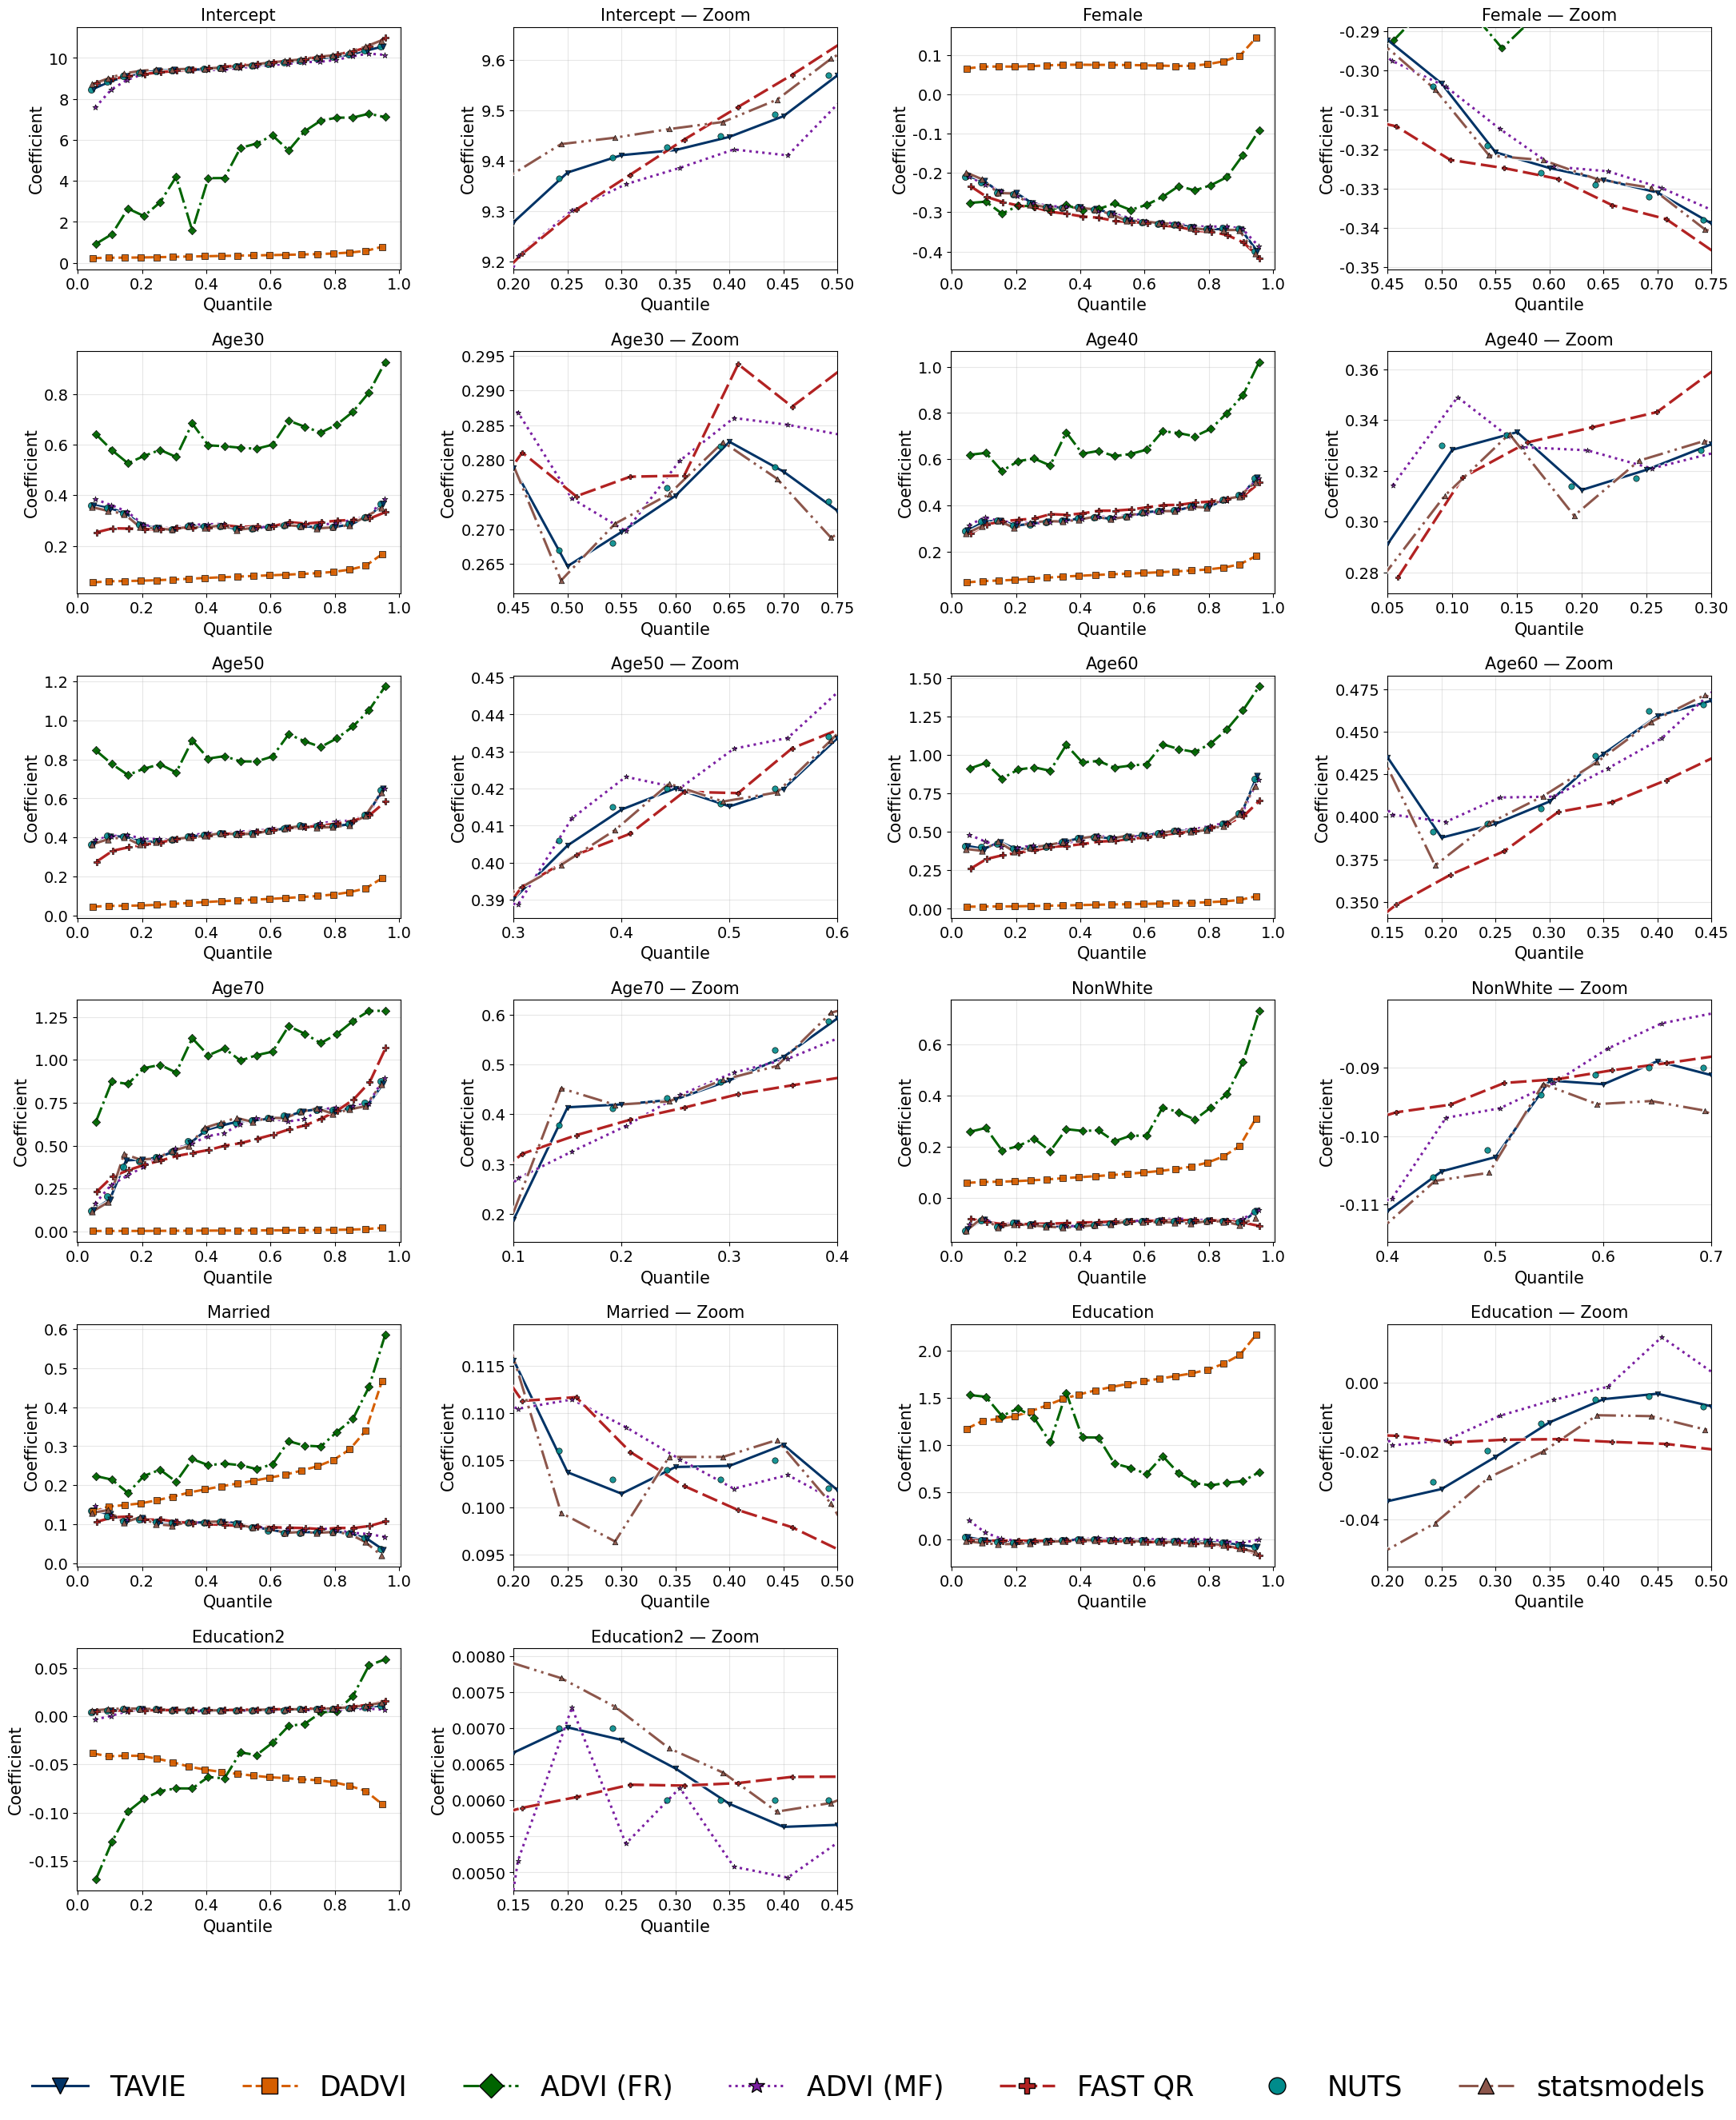

In [101]:

plot_QR_results_zoom(
    TAVIE_mus=results["TAVIE_mus"],
    DADVI_mus=results["DADVI_mus"],
    ADVI_fr_mus=results["ADVI_fr_mus"],
    ADVI_mf_mus=results["ADVI_mf_mus"],
    FAST_QR_mus=results["FAST_QR_mus"],
    NUTS_mus=results["NUTS_mus"],
    SM_mus=results["SM_mus"],
    quantiles=quantiles,
    feature_names=feature_names,
    skip_intercept=False,
    nrows=6, ncols=4, figsize_per_panel=(5.5, 4.5),
    legend_ncol=None, legend_fontsize=25,
    inset_points=3
)

In [102]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patheffects as pe

def plot_QR_results(
    TAVIE_mus,
    DADVI_mus, 
    ADVI_fr_mus, 
    ADVI_mf_mus, 
    FAST_QR_mus,
    NUTS_mus, 
    SM_mus,  
    quantiles, feature_names, skip_intercept=False,
    nrows=6, ncols=4, figsize_per_panel=(3.2, 2.6),
    legend_ncol=None, legend_fontsize=9
):
    # --- stack inputs ---
    qs = np.array(quantiles, dtype=float)
    TAVIE_mat    = np.vstack([np.asarray(TAVIE_mus[u])    for u in qs])
    DADVI_mat    = np.vstack([np.asarray(DADVI_mus[u])    for u in qs])
    ADVI_fr_mat  = np.vstack([np.asarray(ADVI_fr_mus[u])  for u in qs])
    ADVI_mf_mat  = np.vstack([np.asarray(ADVI_mf_mus[u])  for u in qs])
    FAST_QR_mat  = np.vstack([np.asarray(FAST_QR_mus[u])  for u in qs])
    NUTS_mat     = np.vstack([np.asarray(NUTS_mus[u])     for u in qs])
    SM_mat       = np.vstack([np.asarray(SM_mus[u])       for u in qs])

    p = TAVIE_mat.shape[1]
    idx_start = 1 if (skip_intercept and p == len(feature_names)) else 0
    feats_idx = list(range(idx_start, p))
    feats = [feature_names[j] for j in feats_idx]

    max_features = nrows * ncols
    feats_idx = feats_idx[:max_features]
    feats = feats[:max_features]
    nfeats = len(feats_idx)

    fig_w = figsize_per_panel[0] * ncols
    fig_h = figsize_per_panel[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.ravel()

    x_jitter = {
        "TAVIE": 0.000, "DADVI": -0.004, "ADVI (FR)": 0.006,
        "ADVI (MF)": 0.004, "FAST QR": 0.008, "NUTS": -0.008, "statsmodels": -0.006
    }
    method_styles = [
        ("TAVIE",       "-",                     "#003366",  "v",   2.2, TAVIE_mat),
        ("DADVI",       "--",                    "#D55E00",  "s",   2.2, DADVI_mat),
        ("ADVI (FR)",   "-.",                    "#006400",  "D",   2.2, ADVI_fr_mat),
        ("ADVI (MF)",   ":",                     "#7B1FA2",  "*",   2.2, ADVI_mf_mat),
        ("FAST QR",     (0, (6, 2)),             "#B22222",  "P",   2.4, FAST_QR_mat),
        ("NUTS",        "markers_only",          "#008B8B",  "o",   0.0, NUTS_mat),
        ("statsmodels", (0, (8, 2, 1, 2, 1, 2)), "#8C564B",  "^",   2.2, SM_mat),
    ]
    outline = [pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9), pe.Normal()]

    for k, j in enumerate(feats_idx):
        ax = axes[k]
        for name, ls, color, marker, lw, mat in method_styles:
            x = qs + x_jitter.get(name, 0.0)
            if name == "NUTS":
                ax.scatter(x, mat[:, j],
                           label=name, color=color, marker=marker,
                           s=34, alpha=0.9, zorder=4,
                           linewidths=0.5, edgecolors="black")
            else:
                if lw > 0:
                    ax.plot(x, mat[:, j], linestyle=ls, color=color, linewidth=lw,
                            label=name, zorder=3, path_effects=outline)
                ax.scatter(x, mat[:, j], color=color, marker=marker,
                           s=28, alpha=0.95, zorder=5,
                           edgecolors="black", linewidths=0.5)

        ax.set_title(feats[k], fontsize=15)
        ax.set_xlabel("Quantile", fontsize=15)
        ax.set_ylabel("Estimated Coefficient", fontsize=15)
        ax.grid(True, alpha=0.3)

    total_panels = nrows * ncols
    for idx in range(nfeats, total_panels):
        axes[idx].axis("off")

    legend_handles = []
    for name, ls, color, marker, lw, _ in method_styles:
        if name == "NUTS":
            legend_handles.append(Line2D([0], [0], marker=marker, color="none",
                                         markerfacecolor=color, markeredgecolor="black",
                                         markersize=7, label=name))
        else:
            legend_handles.append(Line2D([0], [0], color=color, linestyle=ls,
                                         marker=marker, markerfacecolor=color,
                                         markeredgecolor="black", markersize=12,
                                         linewidth=max(lw, 1.5), label=name))

    if legend_ncol is None:
        legend_ncol = len(legend_handles)

    # Make plots fill figure, minimal reserved space for legend
    plt.tight_layout(rect=[0, 0.04, 1, 1])  # small bottom gap only
    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=legend_ncol,
        frameon=False,
        fontsize=legend_fontsize,
        bbox_to_anchor=(0.5, 0.0)  # pull legend up close to plots
    )

    plt.show()


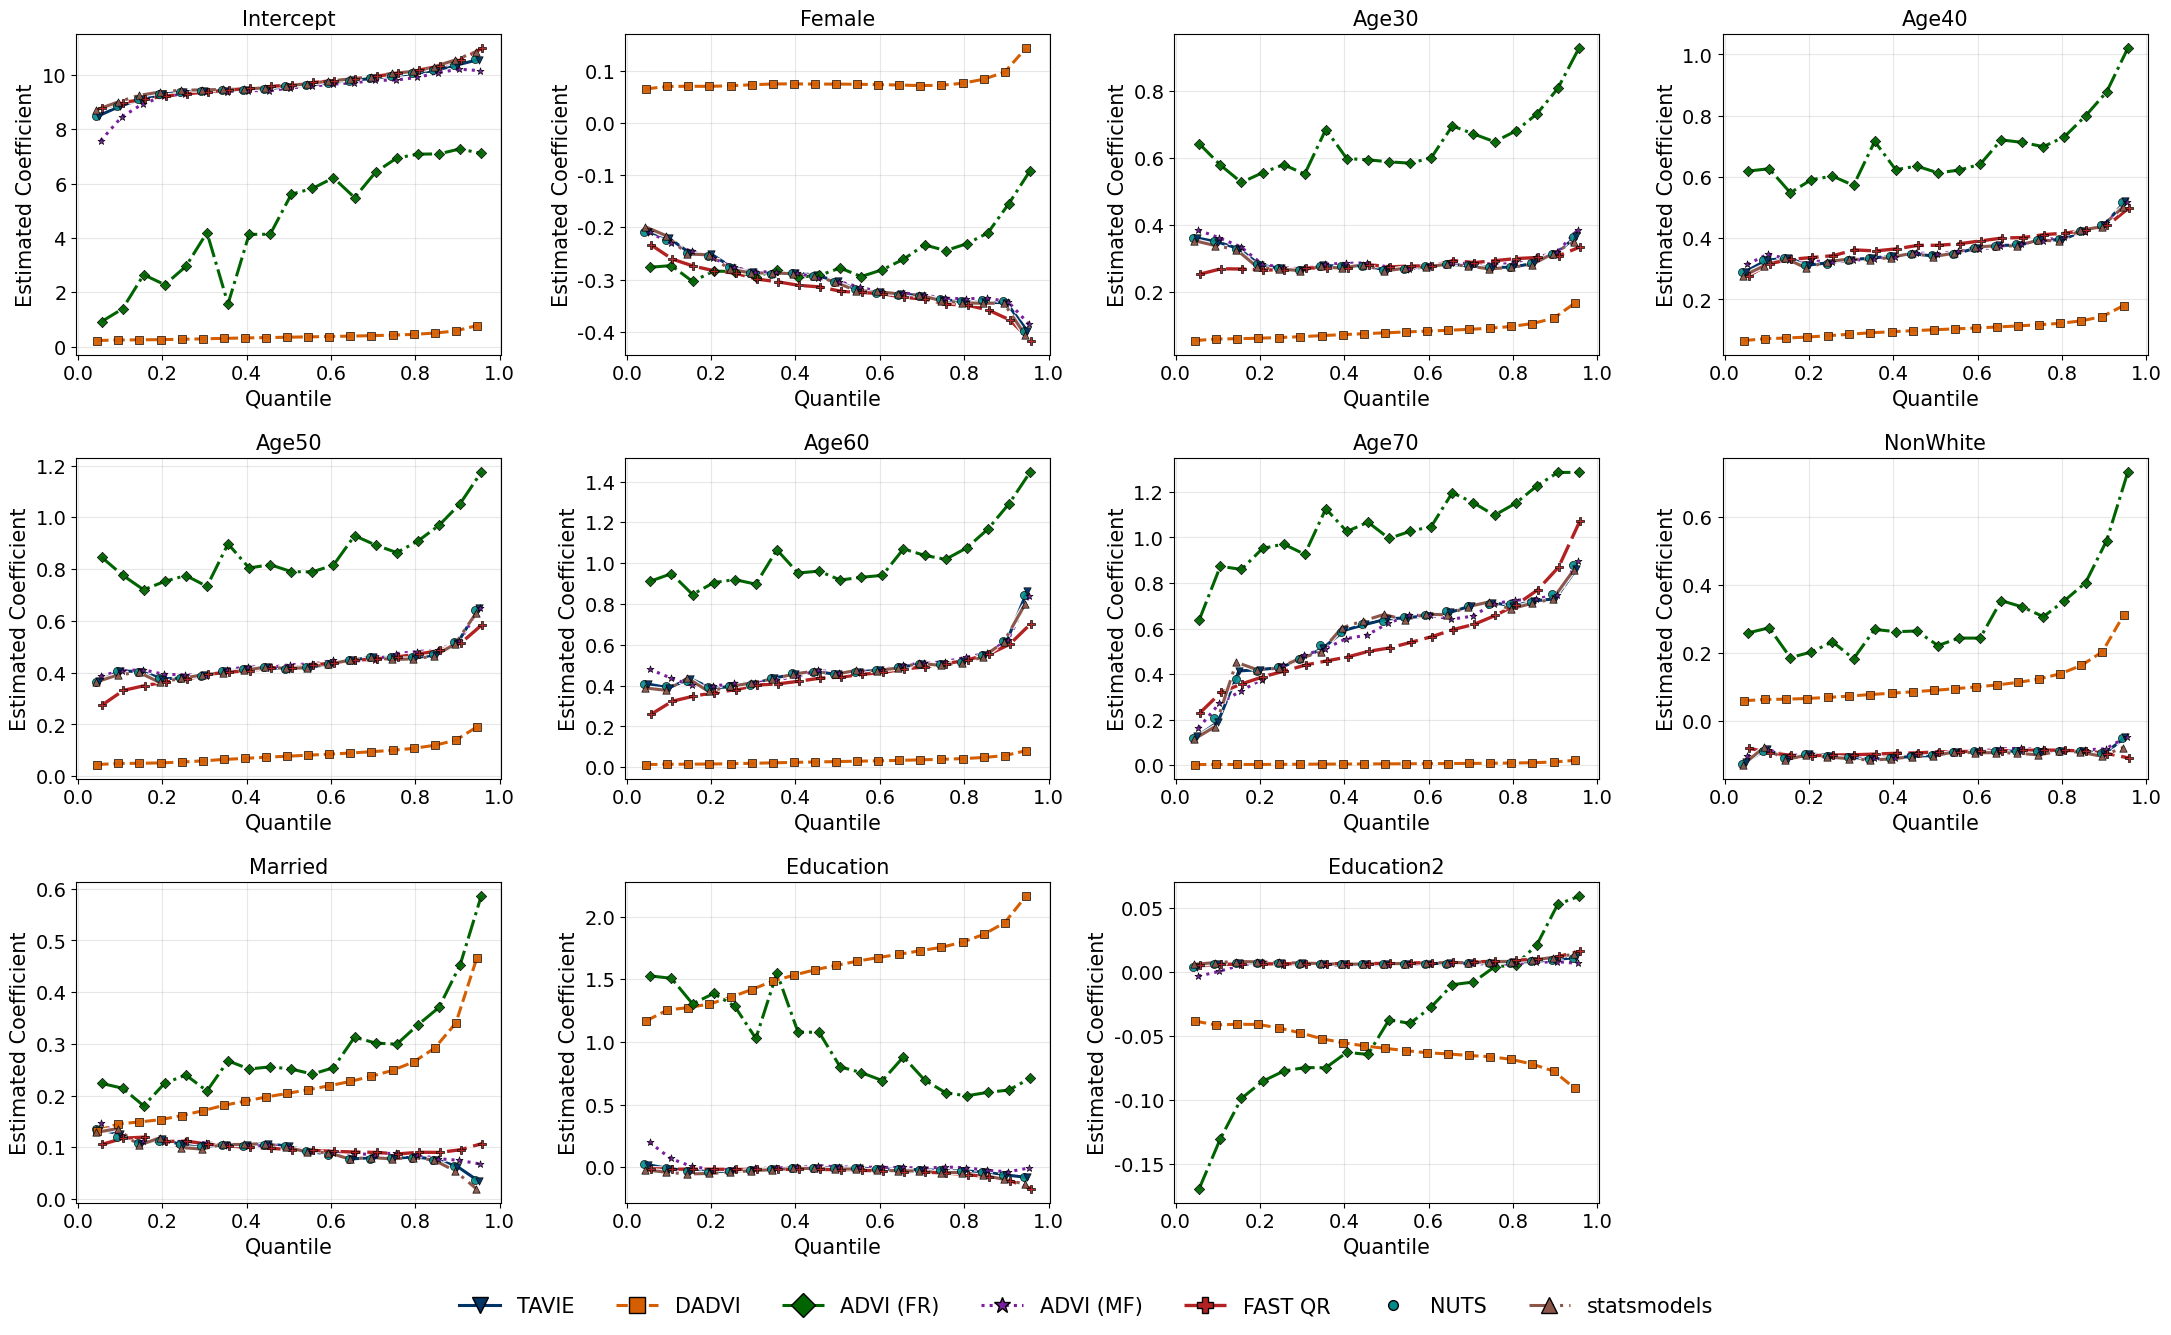

In [103]:

plot_QR_results(
    TAVIE_mus=results["TAVIE_mus"],
    DADVI_mus=results["DADVI_mus"],
    ADVI_fr_mus=results["ADVI_fr_mus"],
    ADVI_mf_mus=results["ADVI_mf_mus"],
    FAST_QR_mus=results["FAST_QR_mus"],
    NUTS_mus=results["NUTS_mus"],
    SM_mus=results["SM_mus"],
    quantiles=quantiles,
    feature_names=feature_names,
    skip_intercept=False,
     nrows=3, ncols=4, figsize_per_panel=(5.5, 4.5),
    legend_ncol=None, legend_fontsize=15
)

### This is for plotting selected features

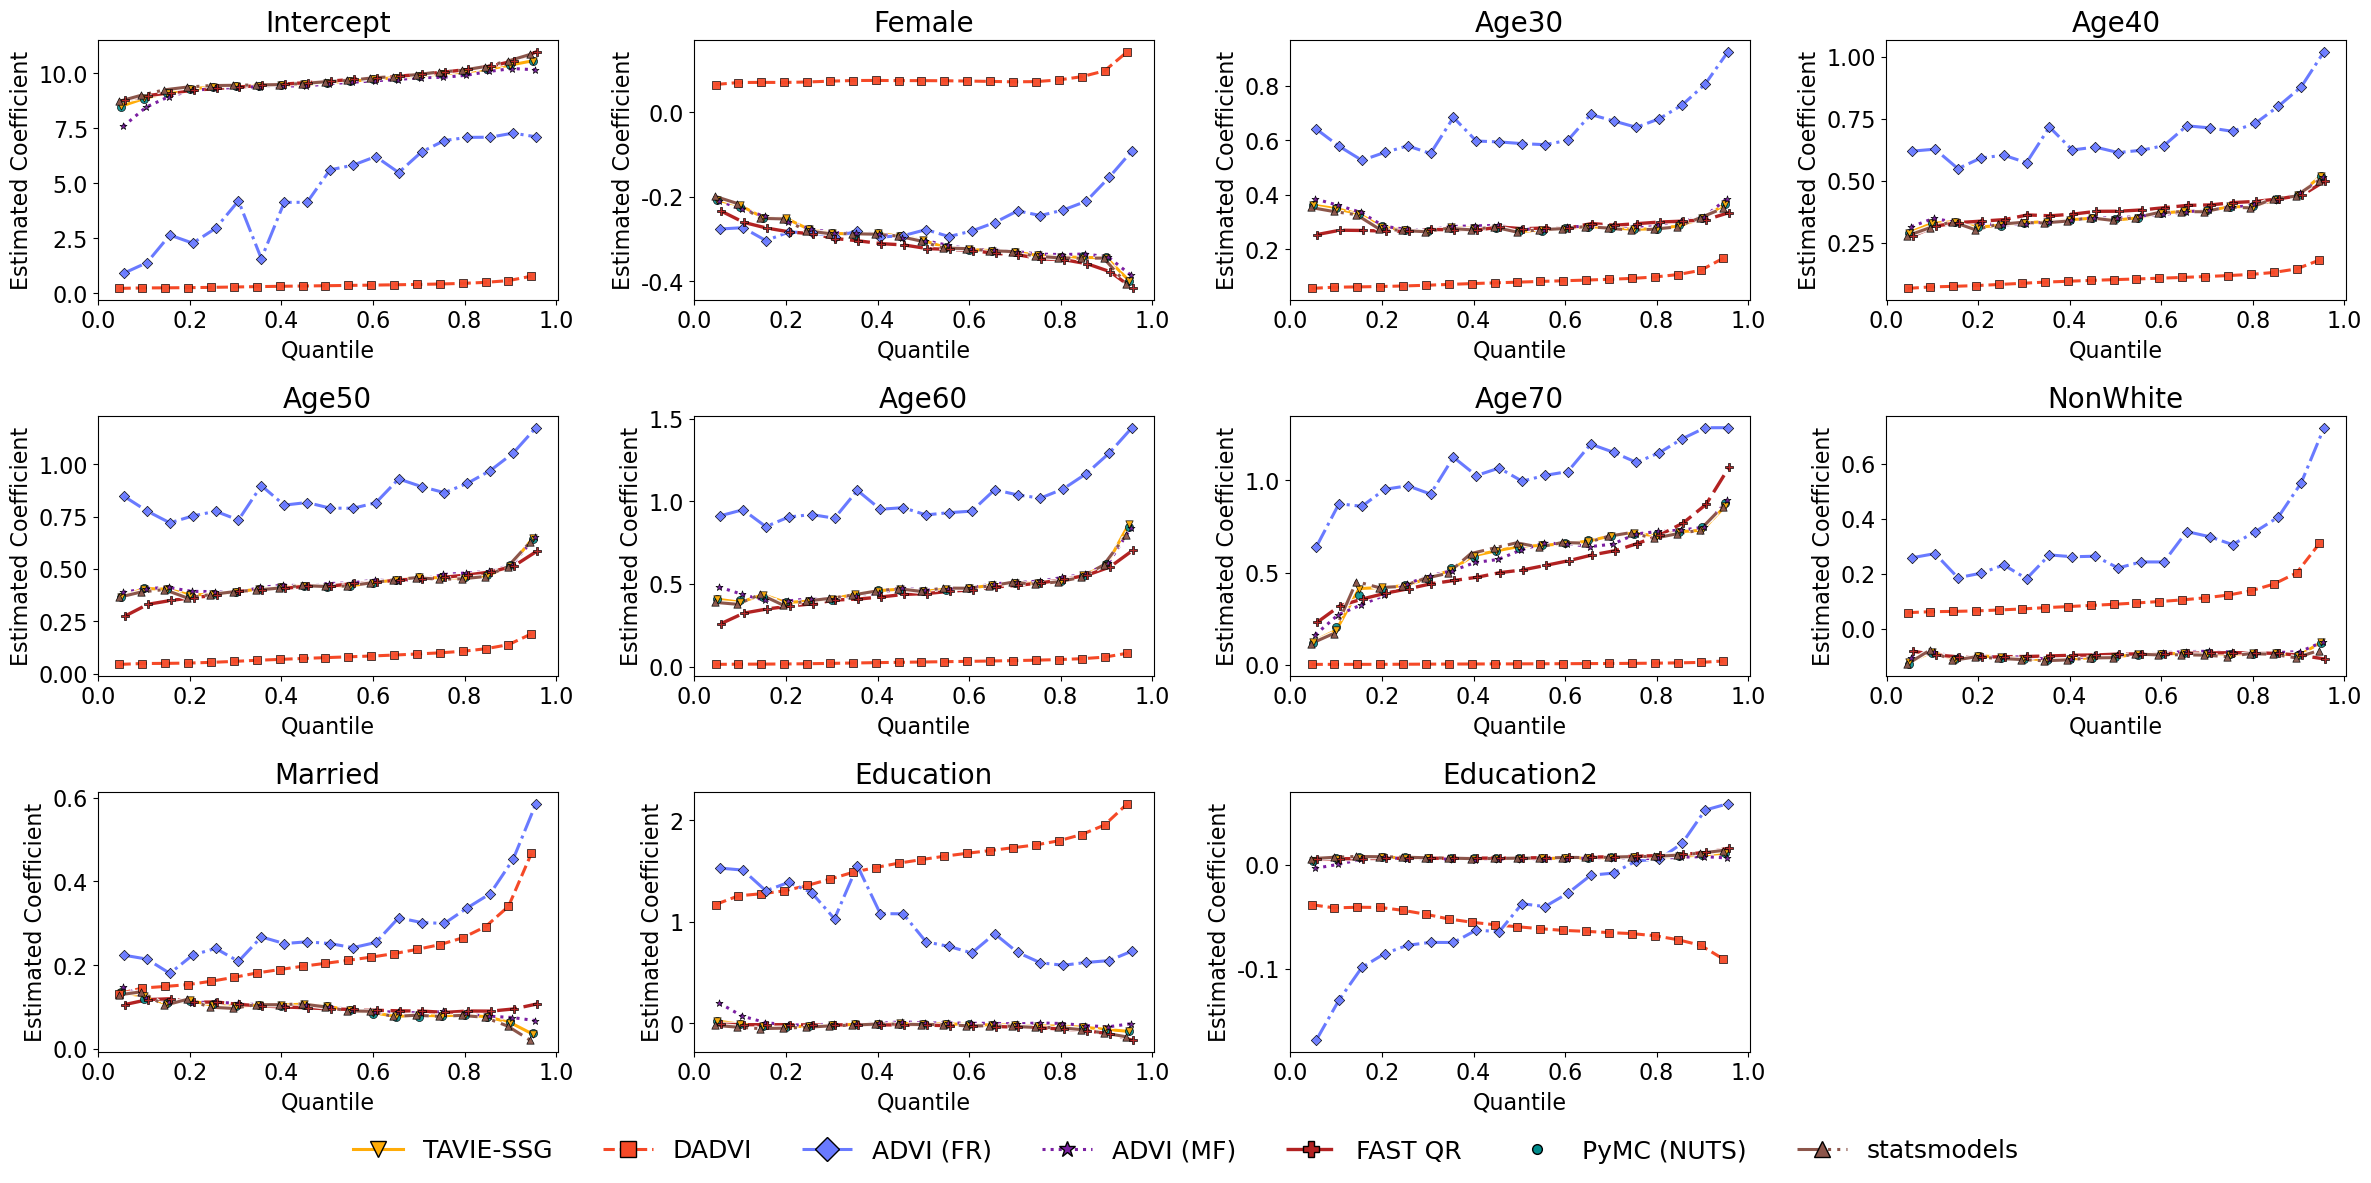

In [147]:
def plot_QR_results_selected(
    TAVIE_mus,
    DADVI_mus, 
    ADVI_fr_mus, 
    ADVI_mf_mus, 
    FAST_QR_mus,
    NUTS_mus, 
    SM_mus,  
    quantiles, feature_names,
    selected_features=None,   # <--- NEW
    skip_intercept=False,
    nrows=6, ncols=4, figsize_per_panel=(3.2, 2.6),
    legend_ncol=None, legend_fontsize=9,
    save_path="",   # <--- NEW PARAM
    dpi=300 
):
    # --- stack inputs ---
    qs = np.array(quantiles, dtype=float)
    TAVIE_mat    = np.vstack([np.asarray(TAVIE_mus[u])    for u in qs])
    DADVI_mat    = np.vstack([np.asarray(DADVI_mus[u])    for u in qs])
    ADVI_fr_mat  = np.vstack([np.asarray(ADVI_fr_mus[u])  for u in qs])
    ADVI_mf_mat  = np.vstack([np.asarray(ADVI_mf_mus[u])  for u in qs])
    FAST_QR_mat  = np.vstack([np.asarray(FAST_QR_mus[u])  for u in qs])
    NUTS_mat     = np.vstack([np.asarray(NUTS_mus[u])     for u in qs])
    SM_mat       = np.vstack([np.asarray(SM_mus[u])       for u in qs])

    mats = {
        "TAVIE-SSG": TAVIE_mat,
        "DADVI": DADVI_mat,
        "ADVI (FR)": ADVI_fr_mat,
        "ADVI (MF)": ADVI_mf_mat,
        "FAST QR": FAST_QR_mat,
        "PyMC (NUTS)": NUTS_mat,
        "statsmodels": SM_mat,
    }

    p = TAVIE_mat.shape[1]
    idx_start = 1 if (skip_intercept and p == len(feature_names)) else 0

    # --- filter features ---
    if selected_features is not None:
        feats_idx = [feature_names.index(f) for f in selected_features if f in feature_names]
    else:
        feats_idx = list(range(idx_start, p))

    feats = [feature_names[j] for j in feats_idx]
    nfeats = len(feats)

    # --- rest is unchanged except loop uses feats_idx ---
    fig_w = figsize_per_panel[0] * ncols
    fig_h = figsize_per_panel[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.ravel()

    x_jitter = {"TAVIE":0.000,"DADVI":-0.004,"ADVI (FR)":0.006,
                "ADVI (MF)":0.004,"FAST QR":0.008,"NUTS":-0.008,"statsmodels":-0.006}
    method_styles = [
        ("TAVIE-SSG", "-", "#FFAC08", "v", 2.2),
        ("DADVI", "--", "#F54927", "s", 2.2),
        ("ADVI (FR)", "-.", "#697AFF", "D", 2.2),
        ("ADVI (MF)", ":", "#7B1FA2", "*", 2.2),
        ("FAST QR", (0,(6,2)), "#B22222", "P", 2.4),
        ("PyMC (NUTS)", "markers_only", "#008B8B", "o", 0.0),
        ("statsmodels", (0,(8,2,1,2,1,2)), "#8C564B", "^", 2.2),
    ]
    outline = [pe.Stroke(linewidth=4.0, foreground="white", alpha=0.9), pe.Normal()]

    for k, j in enumerate(feats_idx):
        ax = axes[k]
        for name, ls, color, marker, lw in method_styles:
            mat = mats[name]
            x = qs + x_jitter.get(name, 0.0)
            if name == "PyMC (NUTS)":
                ax.scatter(x, mat[:, j], label=name, color=color, marker=marker,
                           s=34, alpha=0.9, zorder=4, linewidths=0.5, edgecolors="black")
            else:
                if lw > 0:
                    ax.plot(x, mat[:, j], linestyle=ls, color=color, linewidth=lw,
                            label=name, zorder=3, path_effects=outline)
                ax.scatter(x, mat[:, j], color=color, marker=marker,
                           s=28, alpha=0.95, zorder=5,
                           edgecolors="black", linewidths=0.5)

        ax.set_title(feats[k], fontsize=20)
        ax.set_xlabel("Quantile", fontsize=16)
        ax.set_ylabel("Estimated Coefficient", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)

        #ax.grid(True, alpha=0.3)

    # Hide extra subplots
    total_panels = nrows * ncols
    for idx in range(nfeats, total_panels):
        axes[idx].axis("off")

    # Legend (same as before)
    legend_handles = []
    for name, ls, color, marker, lw in method_styles:
        if name == "PyMC (NUTS)":
            legend_handles.append(Line2D([0],[0], marker=marker, color="none",
                                         markerfacecolor=color, markeredgecolor="black",
                                         markersize=7, label=name))
        else:
            legend_handles.append(Line2D([0],[0], color=color, linestyle=ls,
                                         marker=marker, markerfacecolor=color,
                                         markeredgecolor="black", markersize=12,
                                         linewidth=max(lw, 1.5), label=name))

    if legend_ncol is None:
        legend_ncol = len(legend_handles)

    plt.tight_layout(rect=[0, 0.04, 1, 1])
    fig.legend(handles=legend_handles, loc="lower center", ncol=legend_ncol,
               frameon=False, fontsize=legend_fontsize, bbox_to_anchor=(0.5,0.0))
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    
plot_QR_results_selected(
TAVIE_mus=results["TAVIE_mus"],
DADVI_mus=results["DADVI_mus"],
ADVI_fr_mus=results["ADVI_fr_mus"],
ADVI_mf_mus=results["ADVI_mf_mus"],
FAST_QR_mus=results["FAST_QR_mus"],
NUTS_mus=results["NUTS_mus"],
SM_mus=results["SM_mus"],
quantiles=quantiles,
feature_names=feature_names,
selected_features=["Intercept", "Female", "Age30", "Age40", "Age50", "Age60", "Age70", "NonWhite", "Married", "Education", "Education2"],
skip_intercept=False,
    nrows=3, ncols=4, figsize_per_panel=(6, 4),
legend_ncol=None, legend_fontsize=18,
save_path = "results_data_study/census_QR/census_estimates_competing_methods_n_10000_all",
dpi=300
)

### To check whether ADVI FR converges

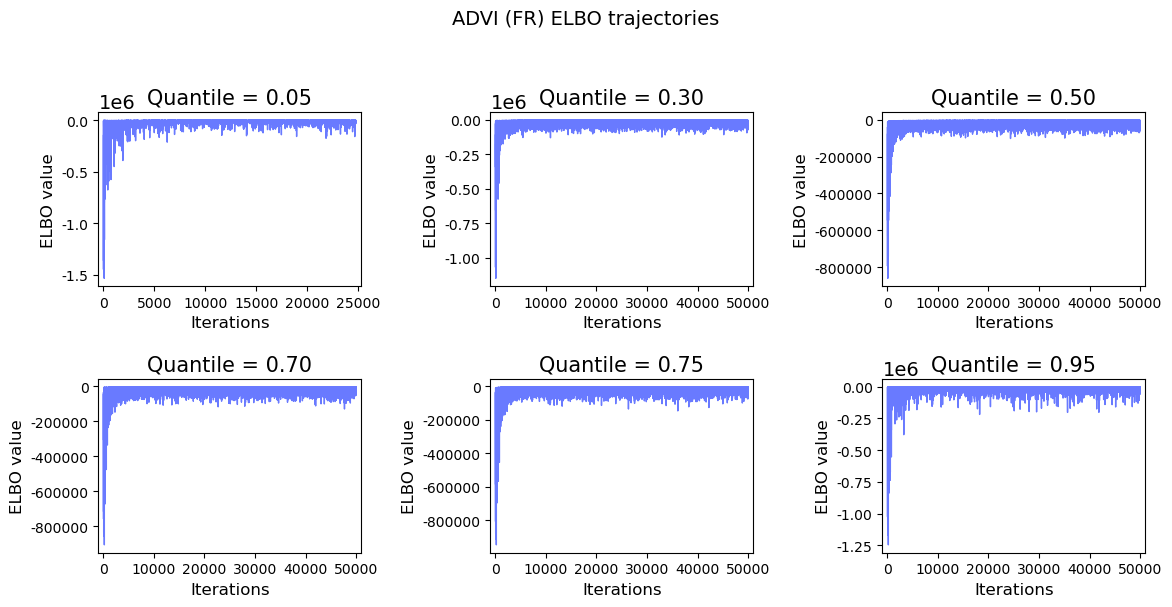

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Pick 6 random unique indices from 0–18
indices = [0, 5, 9, 13, 14, 18]

# Create subplots (2 rows × 3 cols)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for ax, idx in zip(axes, indices):
    q = results['quantiles'][idx]
    elbo_vals = results['ADVI_fr_ELBO'][q]

    ax.plot(elbo_vals, color="#697AFF", linewidth=1)
    ax.set_title(f"Quantile = {q:.2f}", fontsize=15)
    ax.set_xlabel("Iterations", fontsize=12)
    ax.set_ylabel("ELBO value", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.margins(x=0.02)

# Tight layout and figure title
plt.suptitle("ADVI (FR) ELBO trajectories", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f"results_data_study/census_QR/census_ADVI_FR_ELBO.png", dpi=300, bbox_inches='tight')
plt.show()


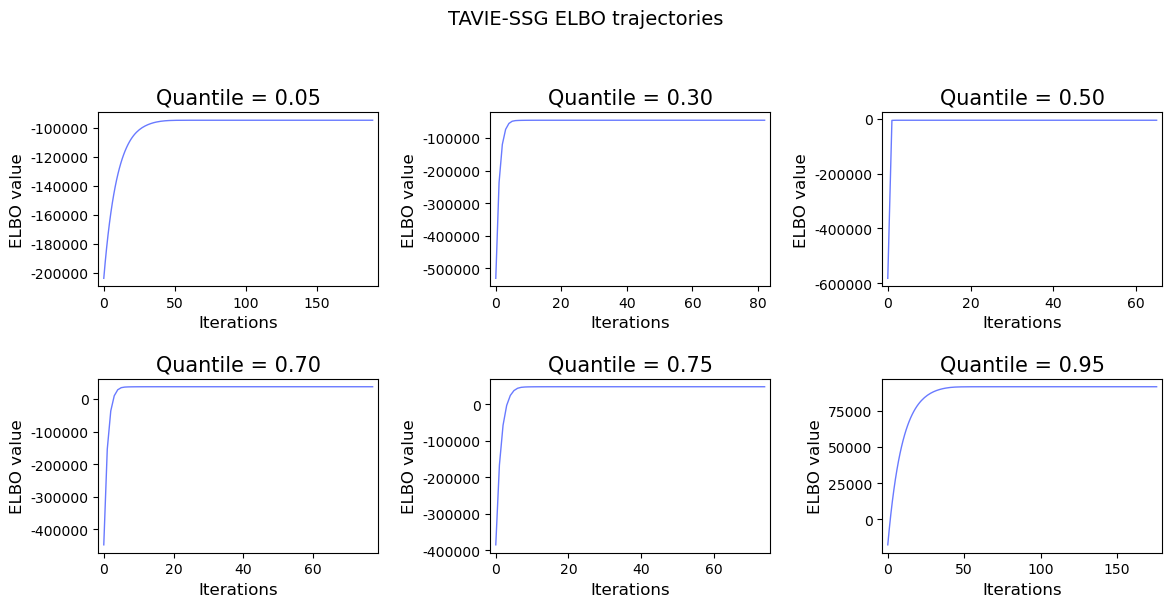

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Pick 6 random unique indices from 0–18
indices = [0, 5, 9, 13, 14, 18]

# Create subplots (2 rows × 3 cols)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for ax, idx in zip(axes, indices):
    q = results['quantiles'][idx]
    elbo_vals = results['TAVIE_ELBO'][q]

    ax.plot(elbo_vals, color="#697AFF", linewidth=1)
    ax.set_title(f"Quantile = {q:.2f}", fontsize=15)
    ax.set_xlabel("Iterations", fontsize=12)
    ax.set_ylabel("ELBO value", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.margins(x=0.02)

# Tight layout and figure title
plt.suptitle("TAVIE-SSG ELBO trajectories", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f"results_data_study/census_QR/census_TAVIE_ELBO.png", dpi=300, bbox_inches='tight')
plt.show()


## Running TAVIE on the original data size for U.S. 2000 Census

In [79]:
# reading census data
dataset = rdata.read_rds("data/Census_data/census.RData")
X = pd.DataFrame(dataset['census_X'])
y = pd.DataFrame(dataset['census_y'])

# sampling 1e6 data points
X_sample = X.sample(n=X.shape[0], random_state=42)
y_sample = y.loc[X_sample.index]
X_sample = X_sample.reset_index(drop=True)
y_sample = y_sample.reset_index(drop=True)

# converting it to numpy nd array
X_sample = X_sample.to_numpy()
y_sample = y_sample.to_numpy().ravel()

### Intializing the TAVIE QR model and running on the Census data to obtain TAVIE estimates

In [ ]:
# Initialize the TAVIE_QR model
QR_model = TAVIE_QR(fit_intercept=False) # intercept already added in the X_sample design matrix

# Fitting the quantile regression using TAVIE_QR
# -------------------------------------------------------------------
p = X_sample.shape[1]
feature_names = ["Intercept", "Female", "Age30", "Age40", "Age50", "Age60", "Age70", "NonWhite", "Married", "Education", "Education2"]

# set up quantiles and storage arrays
quantiles = np.arange(0.05, 0.95 + 1e-8, 0.05)
q = len(quantiles)

# to store the TAVIE estimates and ELBO and also DADVI and NUTS
TAVIE_mus    = {}
TAVIE_sigmas = {}
ELBO = {}

# loop over quantiles
from tqdm import tqdm
for u in tqdm(quantiles, desc="Fitting quantiles"):
    # TAVIE QR
    t0 = perf_counter()
    QR_model.fit(X_sample, y_sample, quantile=u, maxiter = 10000, tol = 1e-6, verbose=False) # fit the TAVIE_QR model
    TAVIE_mus[u] = QR_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
    variational_estimates  = QR_model.get_variational_estimates() # getting the variational estimates
    TAVIE_sigmas[u] = variational_estimates['V_xi']
    ELBO[u] = QR_model.get_elbo()
    print(f'TAVIE done for quantile={u} in {perf_counter()-t0} s.')

### Storing the TAVIE results with original data size

In [ ]:
# Storing the results

# required import
import xarray as xr

# Build the mus DataFrame with row/col names
quantile_labels = [f"Quantile{u:.2f}" for u in quantiles]
mus_df = pd.DataFrame(
    data = np.column_stack([TAVIE_mus[u] for u in quantiles]),
    index = feature_names,
    columns = quantile_labels
)

# Stack the covariances into a (p × p × q) array
Sigmas_array = np.stack([TAVIE_sigmas[u] for u in quantiles], axis=2)

# Wrap that as an xarray DataArray to get named dims & coords
Sigmas_da = xr.DataArray(
    data   = Sigmas_array,
    dims   = ("row_var", "col_var", "quantile"),
    coords = {
      "row_var":   feature_names,
      "col_var":   feature_names,
      "quantile":  quantile_labels
    }
)

# Storing the ELBO history
ELBO_series = pd.Series(
    data  = [ELBO[u] for u in quantiles],
    index = quantile_labels,
    name  = "ELBO"
)

# compute 95% CIs and store as additional DataFrames
ses        = np.sqrt(np.diagonal(Sigmas_array, axis1=0, axis2=1)).T
lower_df   = mus_df - 1.96 * ses
upper_df   = mus_df + 1.96 * ses
lower_df.columns = upper_df.columns = quantile_labels
lower_df.index   = upper_df.index   = feature_names

# Bundle into one results dict
census_tavie_results = {
    "quantiles":   quantiles,
    "mus":         mus_df,
    "Sigmas":      Sigmas_da,
    "lower_CI":    lower_df,
    "upper_CI":    upper_df,
    "ELBO":        ELBO_series
}

import pickle

with open("results_data_study/census_QR/census_tavie_results_original_data_size_Python.pkl", "wb") as f:
    pickle.dump(census_tavie_results, f)

### Plotting the TAVIE QR estimates along with 95% CIs across all quantiles and variables for entire data set result

In [80]:
# reading the tavie results on the entire data set
path_full_data_result = f'results_data_study/census_QR/census_tavie_results_original_data_size_Python.pkl'

tavie_full_result = pd.read_pickle(path_full_data_result)

mus_df = tavie_full_result['mus']
lower_df = tavie_full_result['lower_CI']
upper_df = tavie_full_result['upper_CI']

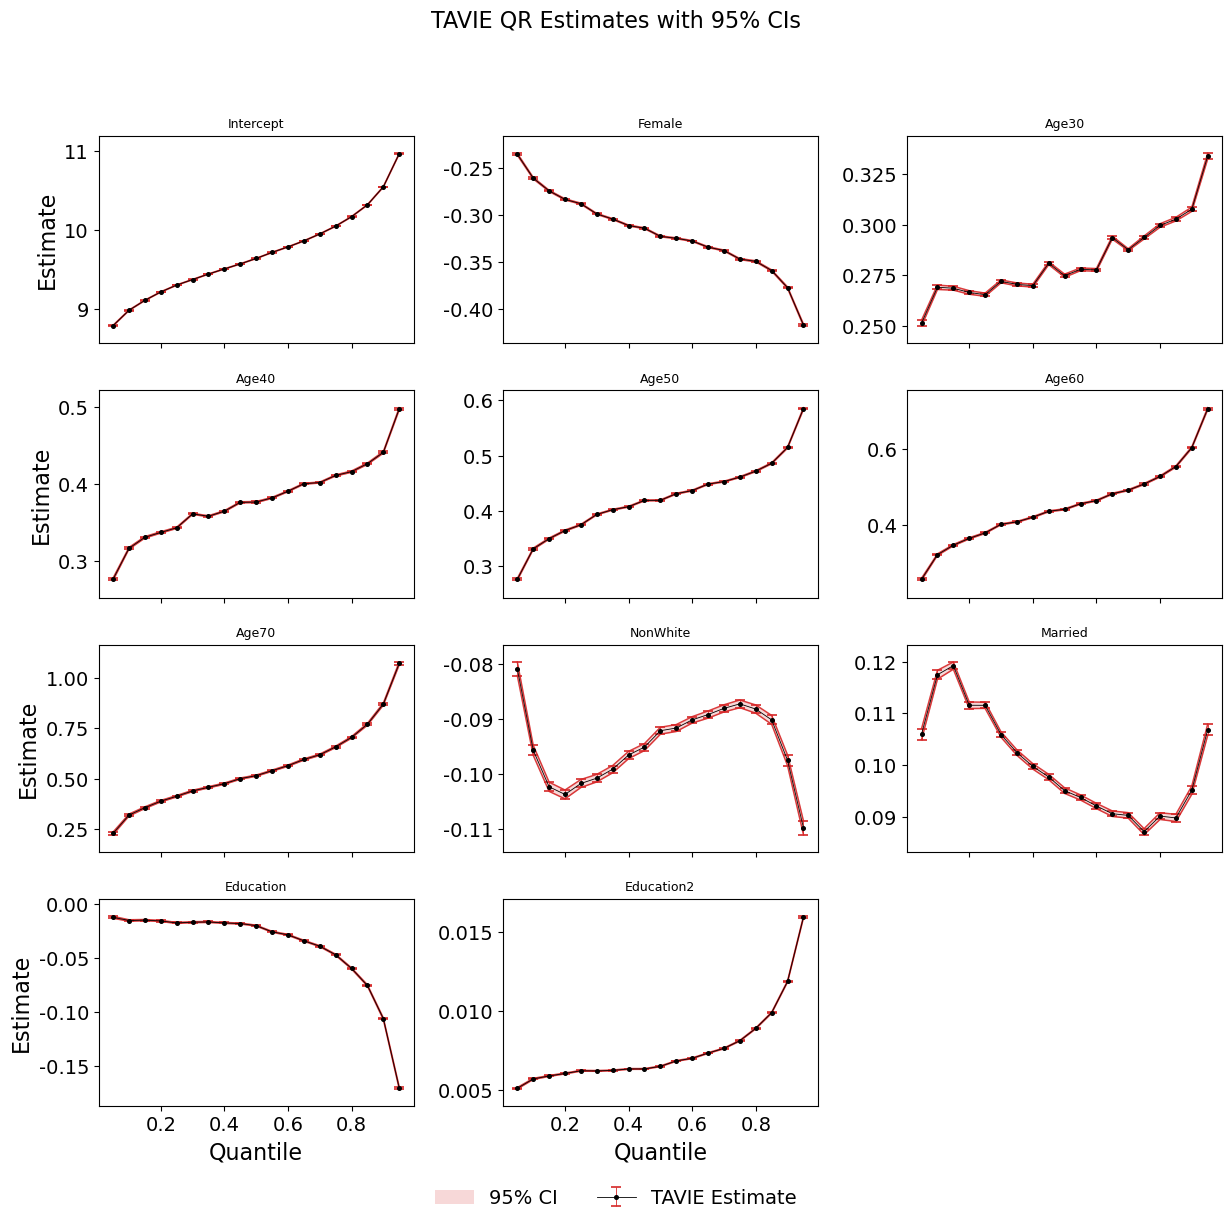

In [75]:
# ─── Re-derive feature names and quantile values ─────────────
features   = mus_df.index.tolist()
quant_vals = [float(col.replace("Quantile","")) for col in mus_df.columns]

cols = 3
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.1), sharex=True)
axes = axes.flatten()

for idx, feat in enumerate(features):
    ax = axes[idx]
    q = np.asarray(quant_vals)
    mu = mus_df.loc[feat].to_numpy()
    lo = lower_df.loc[feat].to_numpy()
    hi = upper_df.loc[feat].to_numpy()

    c_band   = "tab:red"   # band + bounds color
    c_mean   = "black"      # mean line / markers for contrast

    # 95% CI ribbon (translucent) + thicker outline on bounds
    ax.fill_between(q, lo, hi, color=c_band, alpha=0.18,
                    label="95% CI" if idx == 0 else None, zorder=1, linewidth=0)
    ax.plot(q, lo, color=c_band, lw=1.1, alpha=0.9, zorder=2)
    ax.plot(q, hi, color=c_band, lw=1.1, alpha=0.9, zorder=2)

    # Mean line + capped error bars (hi/lo around mean) for visibility
    yerr = np.vstack([mu - lo, hi - mu])  # asymmetric
    ax.errorbar(q, mu, yerr=yerr, fmt='-o',
                markersize=2.6, linewidth=0.6, capsize=3.5, capthick=1.2,
                color=c_mean, ecolor=c_band,
                label="TAVIE Estimate" if idx == 0 else None, zorder=3)

    ax.set_title(feat, fontsize=9)
    if idx % cols == 0:
        ax.set_ylabel("Estimate")
    if idx // cols == rows - 1:
        ax.set_xlabel("Quantile")

    ax.margins(y=0.10)

# turn off unused axes
for ax in axes[len(features):]:
    ax.axis("off")

# common legend
handles, labels = [], []
for h, l in zip(*axes[0].get_legend_handles_labels()):
    if l and l not in labels:
        handles.append(h); labels.append(l)
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
fig.suptitle("TAVIE QR Estimates with 95% CIs", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Plotting only selected features

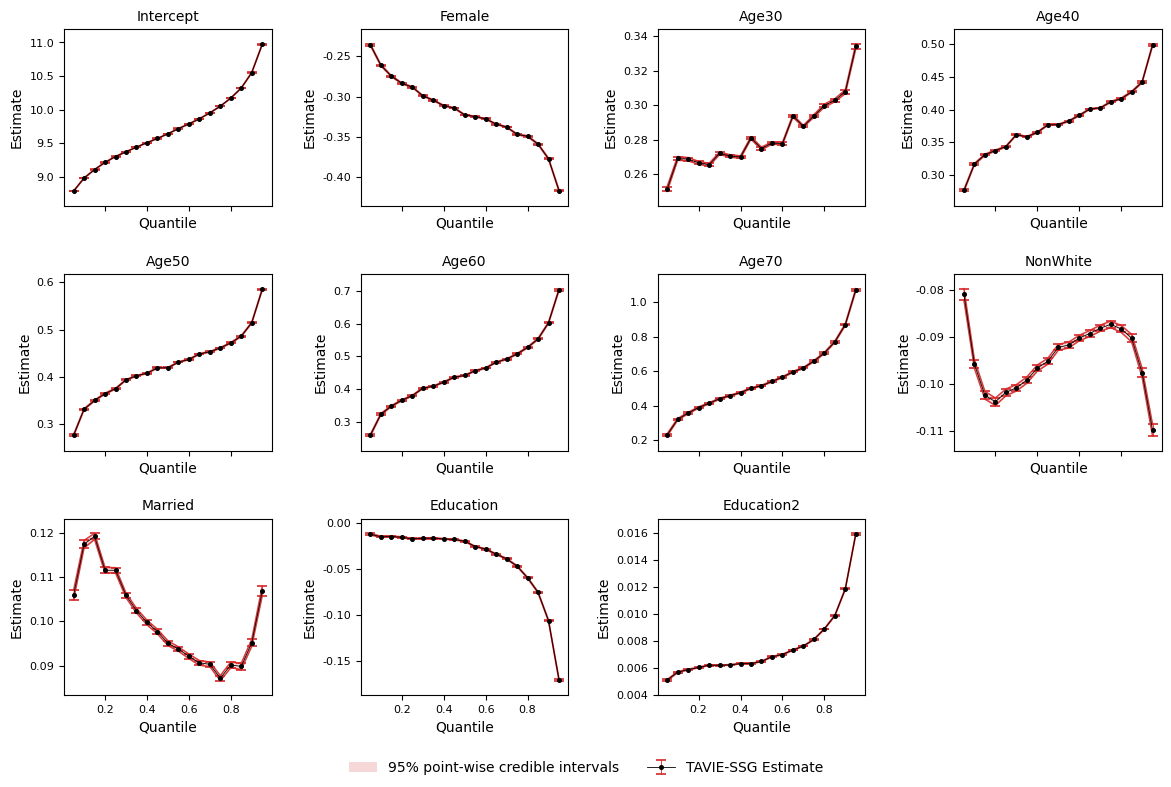

In [144]:
# ─── Choose which features to plot ───────────────────────────
selected_features = ['Intercept', 'Female', 'Age30', 'Age40', 'Age50', 'Age60', 'Age70', 'NonWhite', 'Married', 'Education', 'Education2']   # names or substrings, or indices like [2,5,7]

# Re-derive feature names and quantile values
all_features = list(mus_df.index)
all_features = ['Intercept', 'Female', 'Age30', 'Age40', 'Age50', 'Age60', 'Age70', 'NonWhite', 'Married', 'Education', 'Education2']
quant_vals   = [float(col.replace("Quantile","")) for col in mus_df.columns]

# Resolve selected_features to indices (supports names, substrings, or ints)
sel_idx = []
for sel in selected_features:
    if isinstance(sel, int):
        if 0 <= sel < len(all_features):
            sel_idx.append(sel)
    else:
        # name or substring match (case-insensitive)
        matches = [i for i, f in enumerate(all_features) if sel.lower() in f.lower()]
        sel_idx.extend(matches)

# Deduplicate while preserving order
seen = set()
sel_idx = [i for i in sel_idx if not (i in seen or seen.add(i))]

# Fallback: if nothing matched, plot everything
if not sel_idx:
    sel_idx = list(range(len(all_features)))

features = [all_features[i] for i in sel_idx]

# ─── Plot ────────────────────────────────────────────────────
cols = 4
rows = (len(features) + cols - 1) // cols #cols*4.2, rows*3.1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.8), sharex=True)
axes = axes.flatten()

for idx, feat in enumerate(features):
    ax = axes[idx]
    q  = np.asarray(quant_vals)
    mu = mus_df.loc[feat].to_numpy()
    lo = lower_df.loc[feat].to_numpy()
    hi = upper_df.loc[feat].to_numpy()

    c_band = "tab:red"
    c_mean = "black"

    ax.fill_between(q, lo, hi, color=c_band, alpha=0.18,
                    label="95% point-wise credible intervals" if idx == 0 else None, zorder=1, linewidth=0)
    ax.plot(q, lo, color=c_band, lw=1.1, alpha=0.9, zorder=2)
    ax.plot(q, hi, color=c_band, lw=1.1, alpha=0.9, zorder=2)

    yerr = np.vstack([mu - lo, hi - mu])
    ax.errorbar(q, mu, yerr=yerr, fmt='-o',
                markersize=2.6, linewidth=0.6, capsize=3.5, capthick=1.2,
                color=c_mean, ecolor=c_band,
                label="TAVIE-SSG Estimate" if idx == 0 else None, zorder=3)

    ax.set_title(feat, fontsize=10)
    #if idx % cols == 0:
    ax.set_ylabel("Estimate", fontsize=10)
    #if idx // cols == rows - 1:
    ax.set_xlabel("Quantile", fontsize=10)
    ax.margins(y=0.10)
    
    ax.tick_params(axis='both', which='major', labelsize=8)

# Turn off unused axes
for ax in axes[len(features):]:
    ax.axis("off")

# Common legend
handles, labels = [], []
for h, l in zip(*axes[0].get_legend_handles_labels()):
    if l and l not in labels:
        handles.append(h); labels.append(l)
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False, fontsize=10)
#fig.suptitle("TAVIE QR Estimates with 95% CIs", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(f"results_data_study/census_QR/tavie_QR_estimates_census_all.png", dpi=300, bbox_inches='tight')
plt.show()


### Plotting FAST QR and TAVIE QR results on the full data run

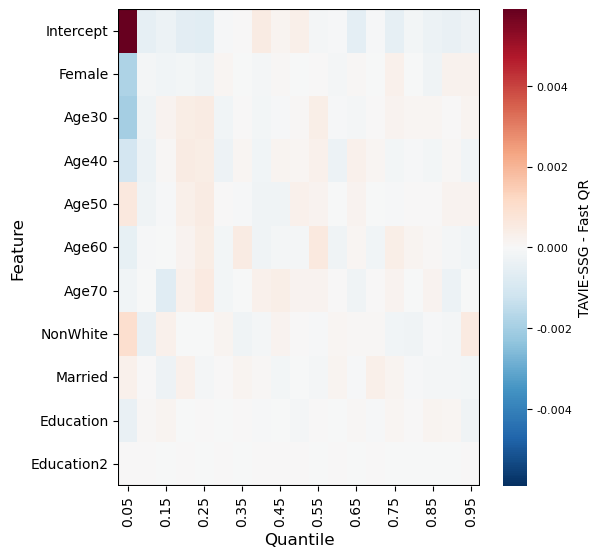

In [98]:
import seaborn as sns
import matplotlib.patches as patches


# Compute differences
diff_df = mus_df - mus_original                   # (features × quantiles)
abs_diff = diff_df.abs()
q_vals   = np.array([float(c.replace("Quantile","")) for c in mus_df.columns])

max_abs = abs_diff.to_numpy().max()
mae_all = abs_diff.to_numpy().mean()

# ─────────────────────────────────────────────────────────────
# Heatmap of differences (features × quantiles)
# ─────────────────────────────────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(6, 5.6)) #plt.subplots(figsize=(max(6, 0.35*len(mus_df.columns)+2), 0.25*len(mus_df.index)+2))
v = abs(diff_df.to_numpy()).max() or 1.0  # symmetric color range around 0
hm = sns.heatmap(
    diff_df, ax=ax2, cmap="RdBu_r", center=0.0, vmin=-v, vmax=v,
    cbar_kws={"label": "TAVIE-SSG - Fast QR"}
)

custom_labels = ["0.05", "0.15", "0.25", "0.35", "0.45", "0.55", "0.65", "0.75", "0.85", "0.95"]
#ax2.set_xticks(np.arange(len(custom_labels)) + 0.5)  # centers the labels
ax2.set_xticklabels(custom_labels, rotation=60, fontsize=10)

ax2.set_xlabel("Quantile", fontsize=12)
ax2.set_ylabel("Feature", fontsize=12)
#ax2.set_title("Heatmap of TAVIE QR and FAST QR estimate difference (centered at 0)", fontsize=12)
# smaller tick labels
ax2.tick_params(axis='x', labelsize=10, rotation=90)
ax2.tick_params(axis='y', labelsize=10)
# smaller colorbar ticks & label
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.set_label("TAVIE-SSG - Fast QR", fontsize=10)

rows, cols = diff_df.shape
rect = patches.Rectangle(
    (0, 0), cols, rows,              # lower-left corner and size
    linewidth=1.5, edgecolor="black", facecolor="none"
)
ax2.add_patch(rect)

plt.tight_layout(pad=0.5)
plt.savefig(f"results_data_study/census_QR/heatmap_tavie_QR_FAST_QR_differences.png", dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
# ─────────────────────────────────────────────────────────────
# Small multiples of the DIFFERENCE per feature
# ─────────────────────────────────────────────────────────────
features = mus_df.index.tolist()
cols = 3
rows = (len(features) + cols - 1) // cols
fig3, axes3 = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.0), sharex=True)
axes3 = axes3.flatten()

for i, feat in enumerate(features):
    ax = axes3[i]
    d  = diff_df.loc[feat].to_numpy()
    ax.axhline(0.0, color='k', lw=0.8, alpha=0.6, zorder=1)
    # Fill + bound lines so even tiny bands are visible
    ax.fill_between(q_vals, 0, d, color="tab:purple", alpha=0.18, zorder=2)
    ax.plot(q_vals, d, color="tab:purple", lw=1.2, zorder=3)
    # add vertical padding based on data spread
    pad = 0.1*np.percentile(np.abs(d), 99) if np.any(d) else 1e-6
    lo, hi = d.min(), d.max()
    lo = min(lo, 0) - pad; hi = max(hi, 0) + pad
    ax.set_ylim(lo, hi)
    ax.set_title(feat, fontsize=9)
    if i % cols == 0:
        ax.set_ylabel(f"TAVIE - Fast-QR", fontsize=10)
    if i // cols == rows - 1:
        ax.set_xlabel("Quantile", fontsize=10)

for ax in axes3[len(features):]:
    ax.axis("off")

fig3.suptitle("Per-feature estimate difference (TAVIE QR - FAST QR) across quantiles", fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Runtime comparison for $10^4$ data points

In [4]:
# Paste your full runtime log here:
text = """
TAVIE done for quantile=0.05 in 0.17975745900000106 s.
ADVI (MF) done for quantile=0.05 in 18.503005166 s.
ADVI (FR) done for quantile=0.05 in 14.651485082999997 s.
DADVI done for quantile=0.05 in 196.069676625 s.
NUTS done for quantile=0.05 in 49.76014900000001 s.
stasmodels done for quantile=0.05 in 0.06681545899999719 s.
TAVIE done for quantile=0.1 in 0.10344854100003431 s.
ADVI (MF) done for quantile=0.1 in 17.129951249999976 s.
ADVI (FR) done for quantile=0.1 in 18.447061874999974 s.
DADVI done for quantile=0.1 in 210.036025 s.
NUTS done for quantile=0.1 in 67.1513175419999 s.
stasmodels done for quantile=0.1 in 0.1812932919999639 s.
TAVIE done for quantile=0.15000000000000002 in 0.10472254199999043 s.
ADVI (MF) done for quantile=0.15000000000000002 in 20.35214795899992 s.
ADVI (FR) done for quantile=0.15000000000000002 in 33.49736870800007 s.
DADVI done for quantile=0.15000000000000002 in 210.4256375 s.
NUTS done for quantile=0.15000000000000002 in 61.60349479199999 s.
stasmodels done for quantile=0.15000000000000002 in 0.05457050000006802 s.
TAVIE done for quantile=0.2 in 0.100812332999908 s.
ADVI (MF) done for quantile=0.2 in 19.11682466700006 s.
ADVI (FR) done for quantile=0.2 in 24.66567679100001 s.
DADVI done for quantile=0.2 in 200.64027637499998 s.
NUTS done for quantile=0.2 in 57.652351082999985 s.
stasmodels done for quantile=0.2 in 0.2854341249999379 s.
TAVIE done for quantile=0.25 in 0.08975741700010076 s.
ADVI (MF) done for quantile=0.25 in 19.495707332999928 s.
ADVI (FR) done for quantile=0.25 in 28.333677667000075 s.
DADVI done for quantile=0.25 in 196.92681245899985 s.
NUTS done for quantile=0.25 in 60.597908167000014 s.
stasmodels done for quantile=0.25 in 0.04861254200000076 s.
TAVIE done for quantile=0.30000000000000004 in 0.08647720900012246 s.
ADVI (MF) done for quantile=0.30000000000000004 in 18.318722292000075 s.
ADVI (FR) done for quantile=0.30000000000000004 in 33.539521040999944 s.
DADVI done for quantile=0.30000000000000004 in 209.98926816699986 s.
NUTS done for quantile=0.30000000000000004 in 59.87426487499988 s.
stasmodels done for quantile=0.30000000000000004 in 0.1186721659998966 s.
TAVIE done for quantile=0.35000000000000003 in 0.07085958399989067 s.
ADVI (MF) done for quantile=0.35000000000000003 in 18.77524625000001 s.
ADVI (FR) done for quantile=0.35000000000000003 in 12.825355583000146 s.
DADVI done for quantile=0.35000000000000003 in 208.12886604100026 s.
NUTS done for quantile=0.35000000000000003 in 49.128150832999836 s.
stasmodels done for quantile=0.35000000000000003 in 0.07221612500006813 s.
TAVIE done for quantile=0.4 in 0.08094274999984918 s.
ADVI (MF) done for quantile=0.4 in 19.30765137499975 s.
ADVI (FR) done for quantile=0.4 in 32.19524716700016 s.
DADVI done for quantile=0.4 in 214.59474233299989 s.
NUTS done for quantile=0.4 in 60.898439083000085 s.
stasmodels done for quantile=0.4 in 0.10533766699973057 s.
TAVIE done for quantile=0.45 in 0.06963725000014165 s.
ADVI (MF) done for quantile=0.45 in 13.461936667000373 s.
ADVI (FR) done for quantile=0.45 in 27.11407504099998 s.
DADVI done for quantile=0.45 in 212.95861675000015 s.
NUTS done for quantile=0.45 in 52.70971062499984 s.
stasmodels done for quantile=0.45 in 0.20003012500001205 s.
TAVIE done for quantile=0.5 in 0.08788533400002052 s.
ADVI (MF) done for quantile=0.5 in 16.356925583000248 s.
ADVI (FR) done for quantile=0.5 in 30.03818395899998 s.
DADVI done for quantile=0.5 in 208.06786754199993 s.
NUTS done for quantile=0.5 in 48.718330416999834 s.
stasmodels done for quantile=0.5 in 0.06256016699990141 s.
TAVIE done for quantile=0.55 in 0.06444874999988315 s.
ADVI (MF) done for quantile=0.55 in 12.691892958000153 s.
ADVI (FR) done for quantile=0.55 in 27.35170516700009 s.
DADVI done for quantile=0.55 in 190.697985625 s.
NUTS done for quantile=0.55 in 58.06466887500028 s.
stasmodels done for quantile=0.55 in 0.04856770900005358 s.
TAVIE done for quantile=0.6000000000000001 in 0.06913741699963794 s.
ADVI (MF) done for quantile=0.6000000000000001 in 13.935158791000049 s.
ADVI (FR) done for quantile=0.6000000000000001 in 28.39662358300029 s.
DADVI done for quantile=0.6000000000000001 in 190.5869655409997 s.
NUTS done for quantile=0.6000000000000001 in 54.7333529589996 s.
stasmodels done for quantile=0.6000000000000001 in 0.07826841699989018 s.
TAVIE done for quantile=0.65 in 0.061098874999970576 s.
ADVI (MF) done for quantile=0.65 in 11.616588832999696 s.
ADVI (FR) done for quantile=0.65 in 25.96842883399995 s.
DADVI done for quantile=0.65 in 177.24406666599998 s.
NUTS done for quantile=0.65 in 52.01612429199986 s.
stasmodels done for quantile=0.65 in 0.058669499999723485 s.
TAVIE done for quantile=0.7000000000000001 in 0.06359879199999341 s.
ADVI (MF) done for quantile=0.7000000000000001 in 12.140274042000328 s.
ADVI (FR) done for quantile=0.7000000000000001 in 30.49529004199985 s.
DADVI done for quantile=0.7000000000000001 in 213.9769369999999 s.
NUTS done for quantile=0.7000000000000001 in 57.50917345800008 s.
stasmodels done for quantile=0.7000000000000001 in 0.12981808399945294 s.
TAVIE done for quantile=0.75 in 0.08424204200036911 s.
ADVI (MF) done for quantile=0.75 in 12.725015625000196 s.
ADVI (FR) done for quantile=0.75 in 30.329209458999685 s.
DADVI done for quantile=0.75 in 200.8044337499996 s.
NUTS done for quantile=0.75 in 57.26772250000067 s.
stasmodels done for quantile=0.75 in 0.08670774999973219 s.
TAVIE done for quantile=0.8 in 0.09837645799962047 s.
ADVI (MF) done for quantile=0.8 in 12.334544250000363 s.
ADVI (FR) done for quantile=0.8 in 33.57137279200015 s.
DADVI done for quantile=0.8 in 209.1613290409996 s.
NUTS done for quantile=0.8 in 65.1580214579999 s.
stasmodels done for quantile=0.8 in 0.07324254200011637 s.
TAVIE done for quantile=0.8500000000000001 in 0.10481037499994272 s.
ADVI (MF) done for quantile=0.8500000000000001 in 19.31671083299989 s.
ADVI (FR) done for quantile=0.8500000000000001 in 29.225641667000673 s.
DADVI done for quantile=0.8500000000000001 in 220.4271401670003 s.
NUTS done for quantile=0.8500000000000001 in 75.5510597499997 s.
stasmodels done for quantile=0.8500000000000001 in 0.10124204099975032 s.
TAVIE done for quantile=0.9 in 0.13240549999954965 s.
ADVI (MF) done for quantile=0.9 in 16.06867175000025 s.
ADVI (FR) done for quantile=0.9 in 30.484952666000027 s.
DADVI done for quantile=0.9 in 200.45342866600004 s.
NUTS done for quantile=0.9 in 63.81477799999993 s.
stasmodels done for quantile=0.9 in 0.14885145800053579 s.
TAVIE done for quantile=0.9500000000000001 in 0.18142979099957302 s.
ADVI (MF) done for quantile=0.9500000000000001 in 12.859112708000794 s.
ADVI (FR) done for quantile=0.9500000000000001 in 31.575826500000403 s.
DADVI done for quantile=0.9500000000000001 in 204.61888566700054 s.
NUTS done for quantile=0.9500000000000001 in 56.59357766700032 s.
stasmodels done for quantile=0.9500000000000001 in 0.0556767910002236 s.
"""

/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_66427/377427079.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


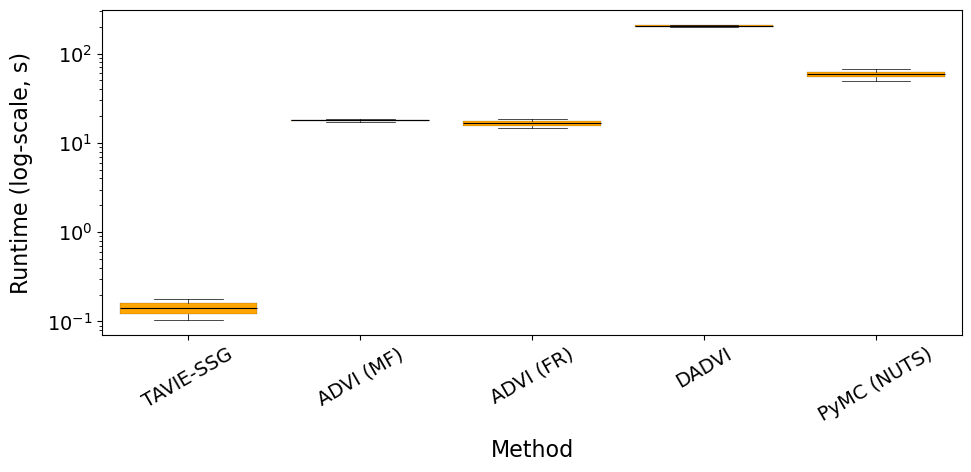

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- Extract data
pattern = r"([\w\s\(\)]+) done for quantile=([\d\.]+) in ([\d\.]+) s"
data = re.findall(pattern, text)

df = pd.DataFrame(data, columns=["Method", "Quantile", "Runtime"])
df["Quantile"] = df["Quantile"].astype(float)
df["Runtime"] = df["Runtime"].astype(float)
df["Method"] = df["Method"].str.strip().replace({
    "stasmodels": "Statsmodels",
    "ADVI (MF)": "ADVI (MF)",
    "ADVI (FR)": "ADVI (FR)",
    "NUTS": "PyMC (NUTS)",
    "TAVIE": "TAVIE-SSG"
})
df = df[df["Method"] != "Statsmodels"].reset_index(drop=True)

plt.rcParams.update({
    "font.family": "sans-serif",     # default font family
    "font.sans-serif": ["DejaVu Sans"],  # explicit default
    "axes.unicode_minus": False      # keep minus signs normal
})

# --- Group runtimes by method
methods = df["Method"].unique()
data_by_method = [df.loc[df["Method"] == m, "Runtime"].values for m in methods]

# --- Font sizes
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18

# --- Create figure
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data_by_method,
    labels=methods,
    showfliers=True,
    patch_artist=True,
    widths=0.8
)

# --- Fill with #BEBADA + black borders
for box in bp["boxes"]:
    box.set(facecolor="#FFA500", edgecolor="black", linewidth=0.1)

for whisker in bp["whiskers"]:
    whisker.set(color="black", linewidth=0.5)

for cap in bp["caps"]:
    cap.set(color="black", linewidth=0.5)

for median in bp["medians"]:
    median.set(color="black", linewidth=0.8)

# --- Optional: log scale
ax.set_yscale("log")

# --- Axis labels, title, font sizes
ax.set_xlabel("Method", fontsize=label_fontsize, labelpad=10)
ax.set_ylabel("Runtime (log-scale, s)", fontsize=label_fontsize, labelpad=10)
#ax.set_title("Runtime Distribution across Quantiles by Method", fontsize=title_fontsize, pad=15)

# --- Tick labels
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xticks(rotation=30)

# --- Light dashed gridlines
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.grid(False)
fig.tight_layout()

fig.savefig(f"results_data_study/census_QR/runtime_comparison_n_10000.png", dpi=300, bbox_inches='tight')

plt.show()